# Performing Calculations

<div>
    <img style='width: 220px;height: 100px;float: left;' src="./Supplementary_data/EODC-Logo-Final.png" height='100px' width='220px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/BMNT_DE_Logo_dreizeilig_srgb.svg" height='100px' width='200px'/> 
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/bmlv.svg" height='100px' width='200px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/LOGO_TUW_GEO.png" height='100px' width='200px'/>
    <img style='width: 100px;height: 100px;float: left;' src="./Supplementary_data/Boku-wien.svg" height='100px' width='100px'/>
    <img style='width: 150px;height: 100px;float: right;' src="./Supplementary_data/ADC_Logo_final_transparent.png" height='100px' width='150px'/>
</div>

This notebook shows how to calculate NDVI and NDWI using the appropriate ACube product. It is required to query for the appropriate measurements and perform some calculations in order to calculate the values. Afterwards the values are classified according to the table below.

| Layer         | Band Combination |   Range  | Layer Classification                                     |
| ------------- |:----------------:| --------:| --------------------------------------------------------:|
| NDVI          | B04, B08         | -1 to 1  | (< 0 Waterbody); 0.2 to 0.4 Grassland/field; >0.5 Forest)| 
| NDWI          | B08, B11         | -1 to 1  | >0.5 Waterbody; <0.5 Land                                |

## Initial setup and metadata/measurements of product

From the output below we can see that the product `B_Sentinel_2` has the required bands (B04, B08, B11).

In [1]:
import matplotlib
import datacube
import pprint
%matplotlib inline
matplotlib.rc('font', size=15)
acube = datacube.Datacube(app='sample_5', env='acube')
products = acube.list_products()
filter = products["platform"]=="Sentinel-2"
products = products.dropna(axis=1).where(filter).dropna()
products.loc[products.name == 'B_Sentinel_2']

name                                 description product_type  \
id                                                                          
16  B_Sentinel_2  Atmospherically corrected Sentinel 2 bands    BOKU_B_S2   

   instrument    platform   format  \
id                                   
16        MSI  Sentinel-2  GeoTIFF   

                                                  crs resolution  \
id                                                                 
16  PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_19...  (-10, 10)   

   spatial_dimensions  
id                     
16             (y, x)

In [2]:
measlist=acube.list_measurements()
measlist.loc[measlist.index.get_level_values(0) == 'B_Sentinel_2']

name   dtype     units  nodata  \
product      measurement                                  
B_Sentinel_2 B02          B02  uint16  fraction       0   
             B03          B03  uint16  fraction       0   
             B04          B04  uint16  fraction       0   
             B05          B05  uint16  fraction       0   
             B06          B06  uint16  fraction       0   
             B07          B07  uint16  fraction       0   
             B08          B08  uint16  fraction       0   
             B8A          B8A  uint16  fraction       0   
             B11          B11  uint16  fraction       0   
             B12          B12  uint16  fraction       0   

                                                      aliases  
product      measurement                                       
B_Sentinel_2 B02             [band_2, band_02, Band2, Band_2]  
             B03             [band_3, band_03, Band3, Band_3]  
             B04             [band_4, band_04, Band4, Band_4]  
             B05             [band_5, band_05, Band5, Band_5]  
             B06             [band_6, band_06, Band6, Band_6]  
             B07             [band_7, band_07, Band7, Band_7]  
             B08             [band_8, band_08, Band8, Band_8]  
             B8A          [band_8a, band_8A, Band8A, Band_8A]  
             B11                   [band_11, Band11, Band_11]  
             B12                   [band_12, Band12, Band_12]

## Querying the data

Below we specify the query parameters. In this case we are also requesting that the cloud cover percentage is less than 5%

In [3]:
query = {
    'product': 'B_Sentinel_2',
    'output_crs': 'EPSG:32633',
    'resolution': (-10, 10),
    'lon': (16.24, 16.4),
    'lat': (47.85, 48.0),
    'time': ('2018-05-01', '2018-05-20'),
    'measurements': ['B04', 'B08', 'B11'], 
    'cloud_cover_percentage': (0.0, 5.0)
}
data = acube.load(**query)
data

<xarray.Dataset>
Dimensions:      (time: 9, x: 1225, y: 1688)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-03 2018-05-04 ... 2018-05-19
  * y            (y) float64 5.317e+06 5.317e+06 5.317e+06 ... 5.3e+06 5.3e+06
  * x            (x) float64 5.925e+05 5.925e+05 ... 6.047e+05 6.047e+05
    spatial_ref  int32 32633
Data variables:
    B04          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    B08          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    B11          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

## Calculation

Formulas for NDVI and NDWI are below. They are applied on the quried data.

$ndvi = (\frac{B08 - B04}{B08 + B04})$

$ndwi = (\frac{B08 - B11}{B08 + B11})$  

In [4]:
data_new = data.where(data.B04 != 0).dropna(dim='time')

ndvi = ((data_new.B08-data_new.B04)/(data_new.B08+data_new.B04))

ndwi = ((data_new.B08-data_new.B11)/(data_new.B08+data_new.B11))

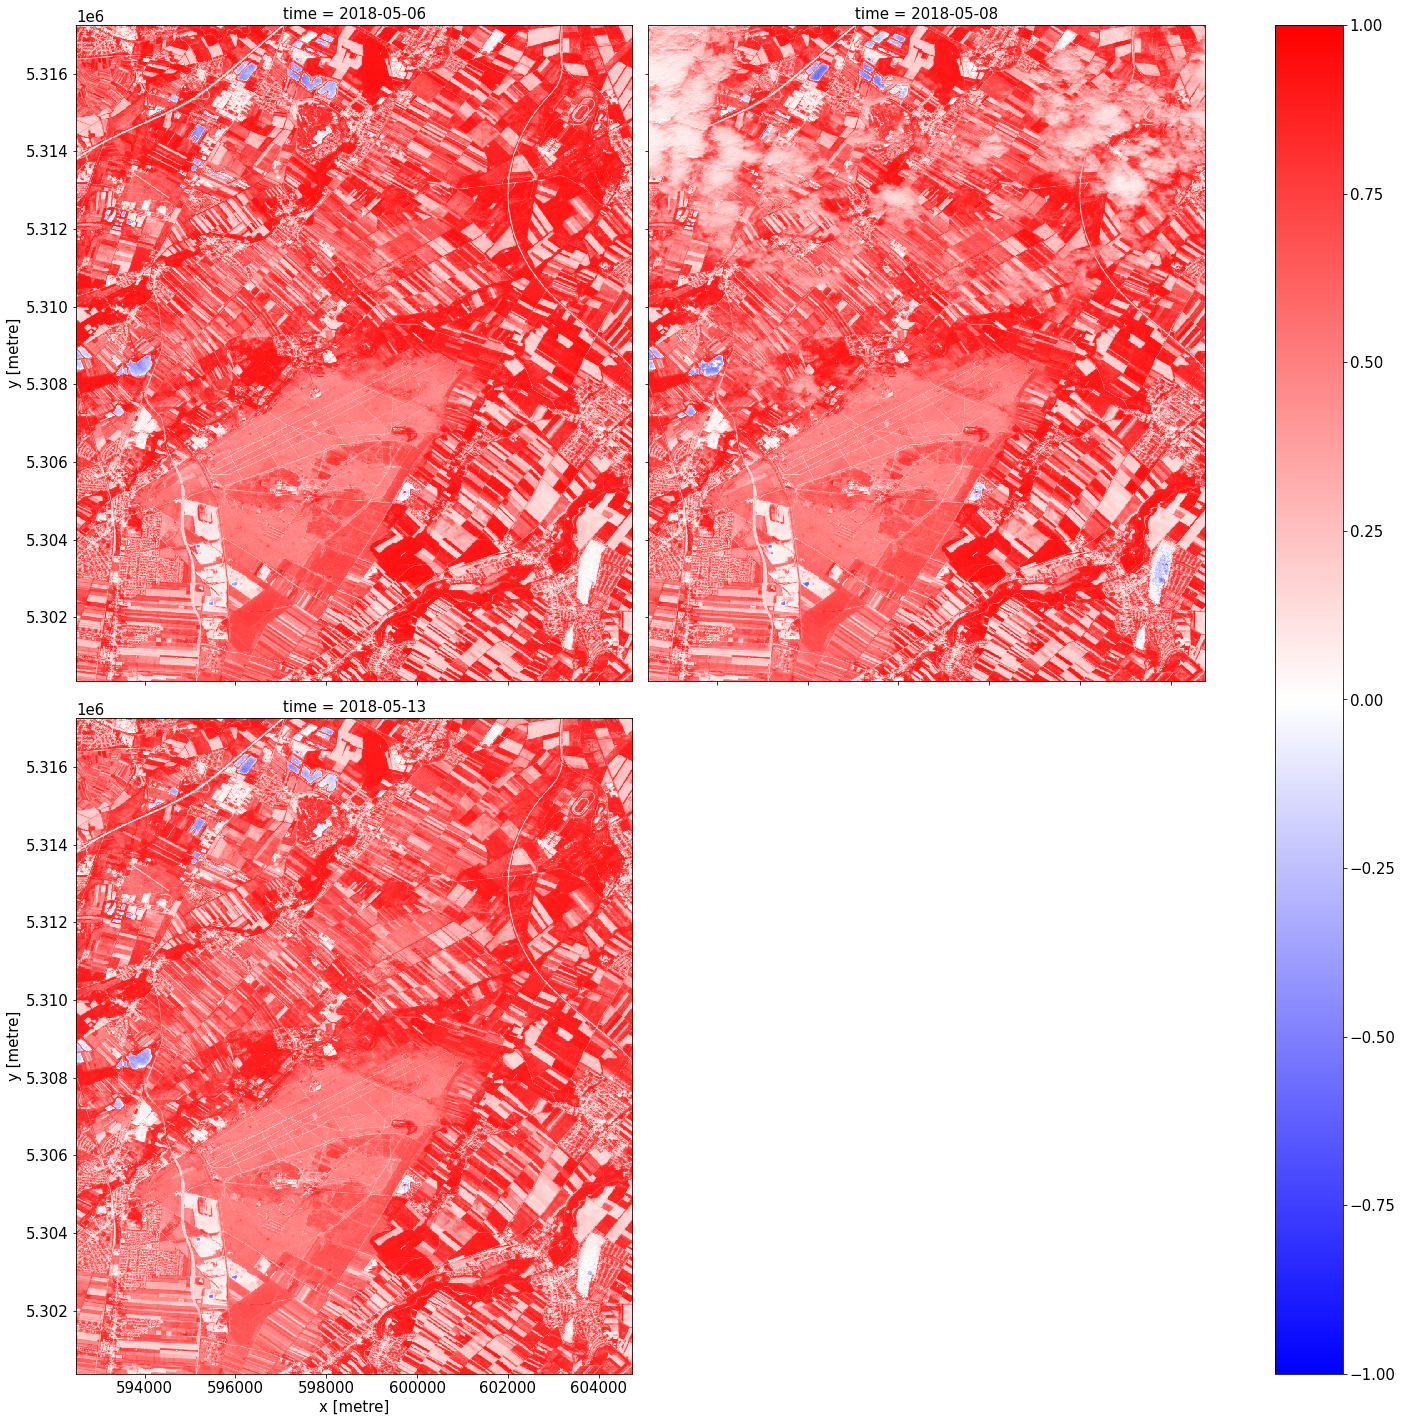

In [5]:
ndvi.plot.imshow(x='x', 
                 y='y',
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='bwr',
                 vmin=-1, 
                 vmax=1)

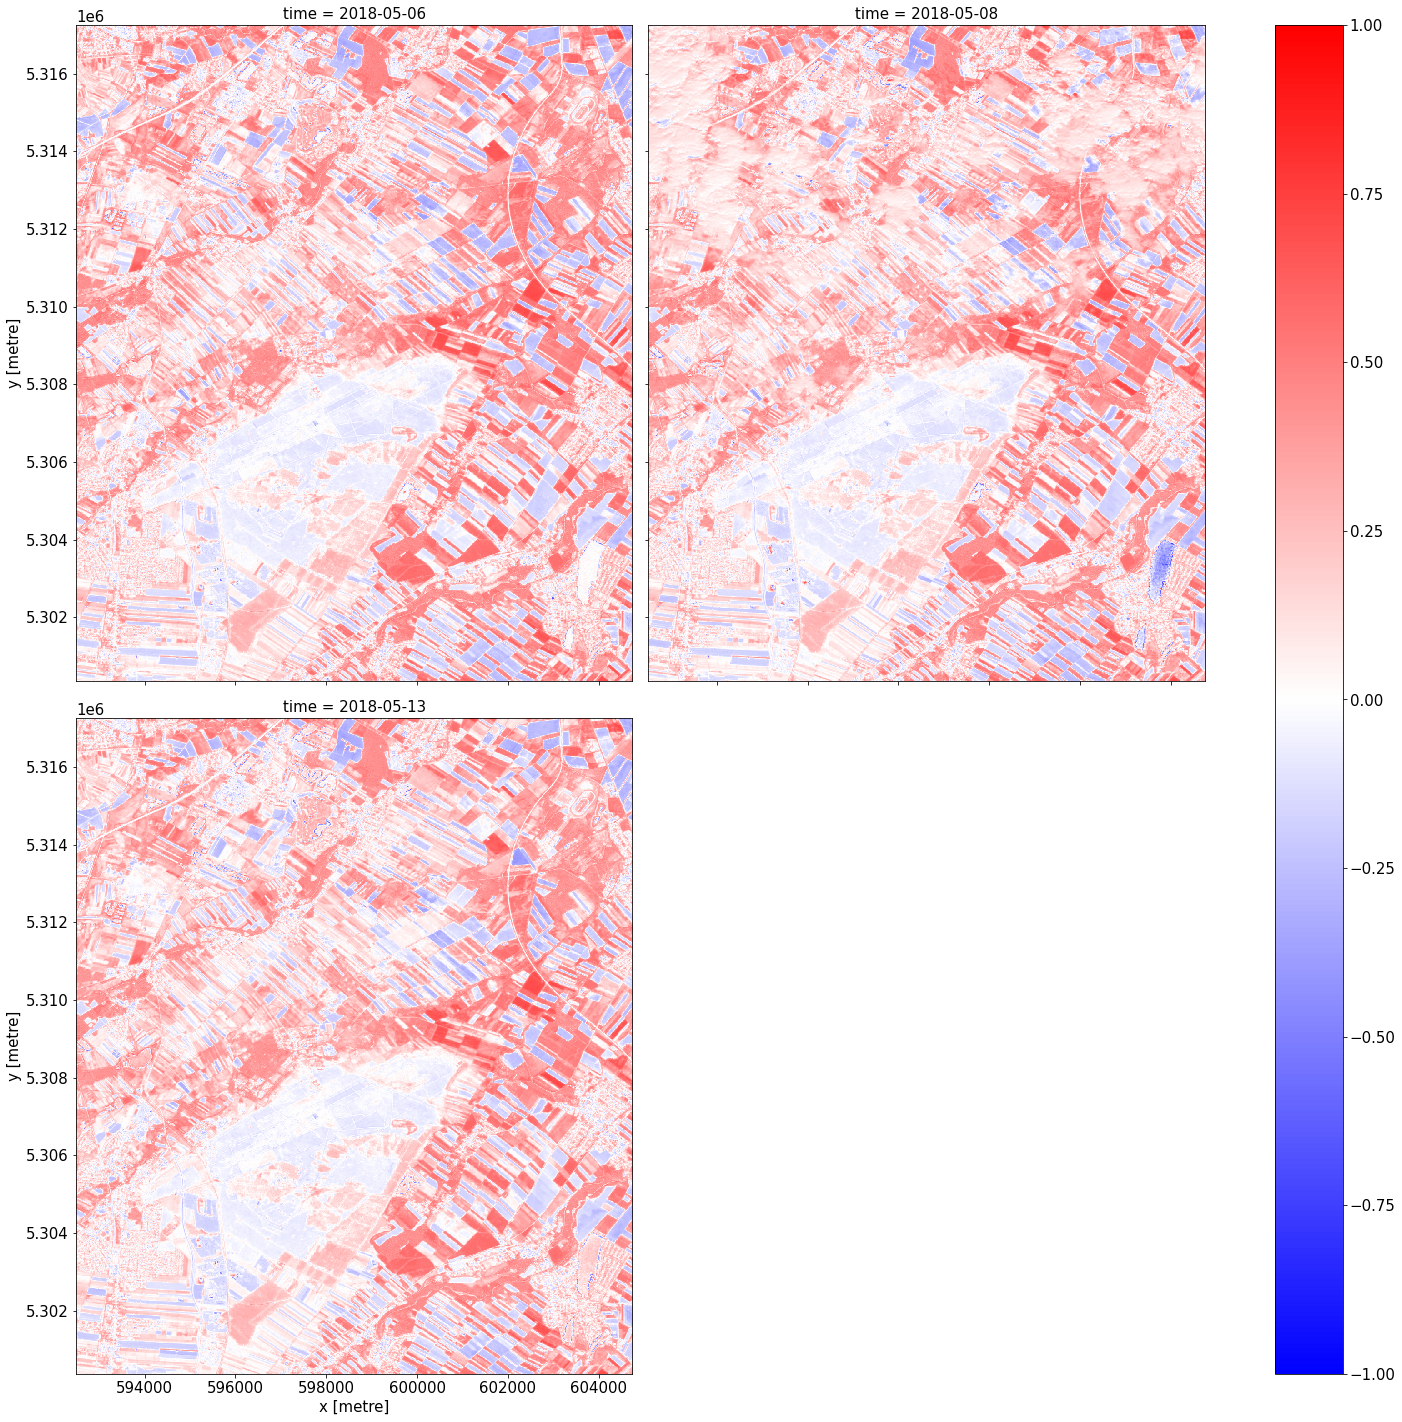

In [6]:
ndwi.plot.imshow(x='x', 
                 y='y',
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='bwr',
                 vmin=-1, 
                 vmax=1)

## Classification of the data

### NDVI Classification

* 1 - Waterbody x <=0
* 2 - Soil - 0 < x <= 0.2
* 3 - Grassland/field - 0.2 < x <= 0.5
* 4 - Forest - x > 0.5

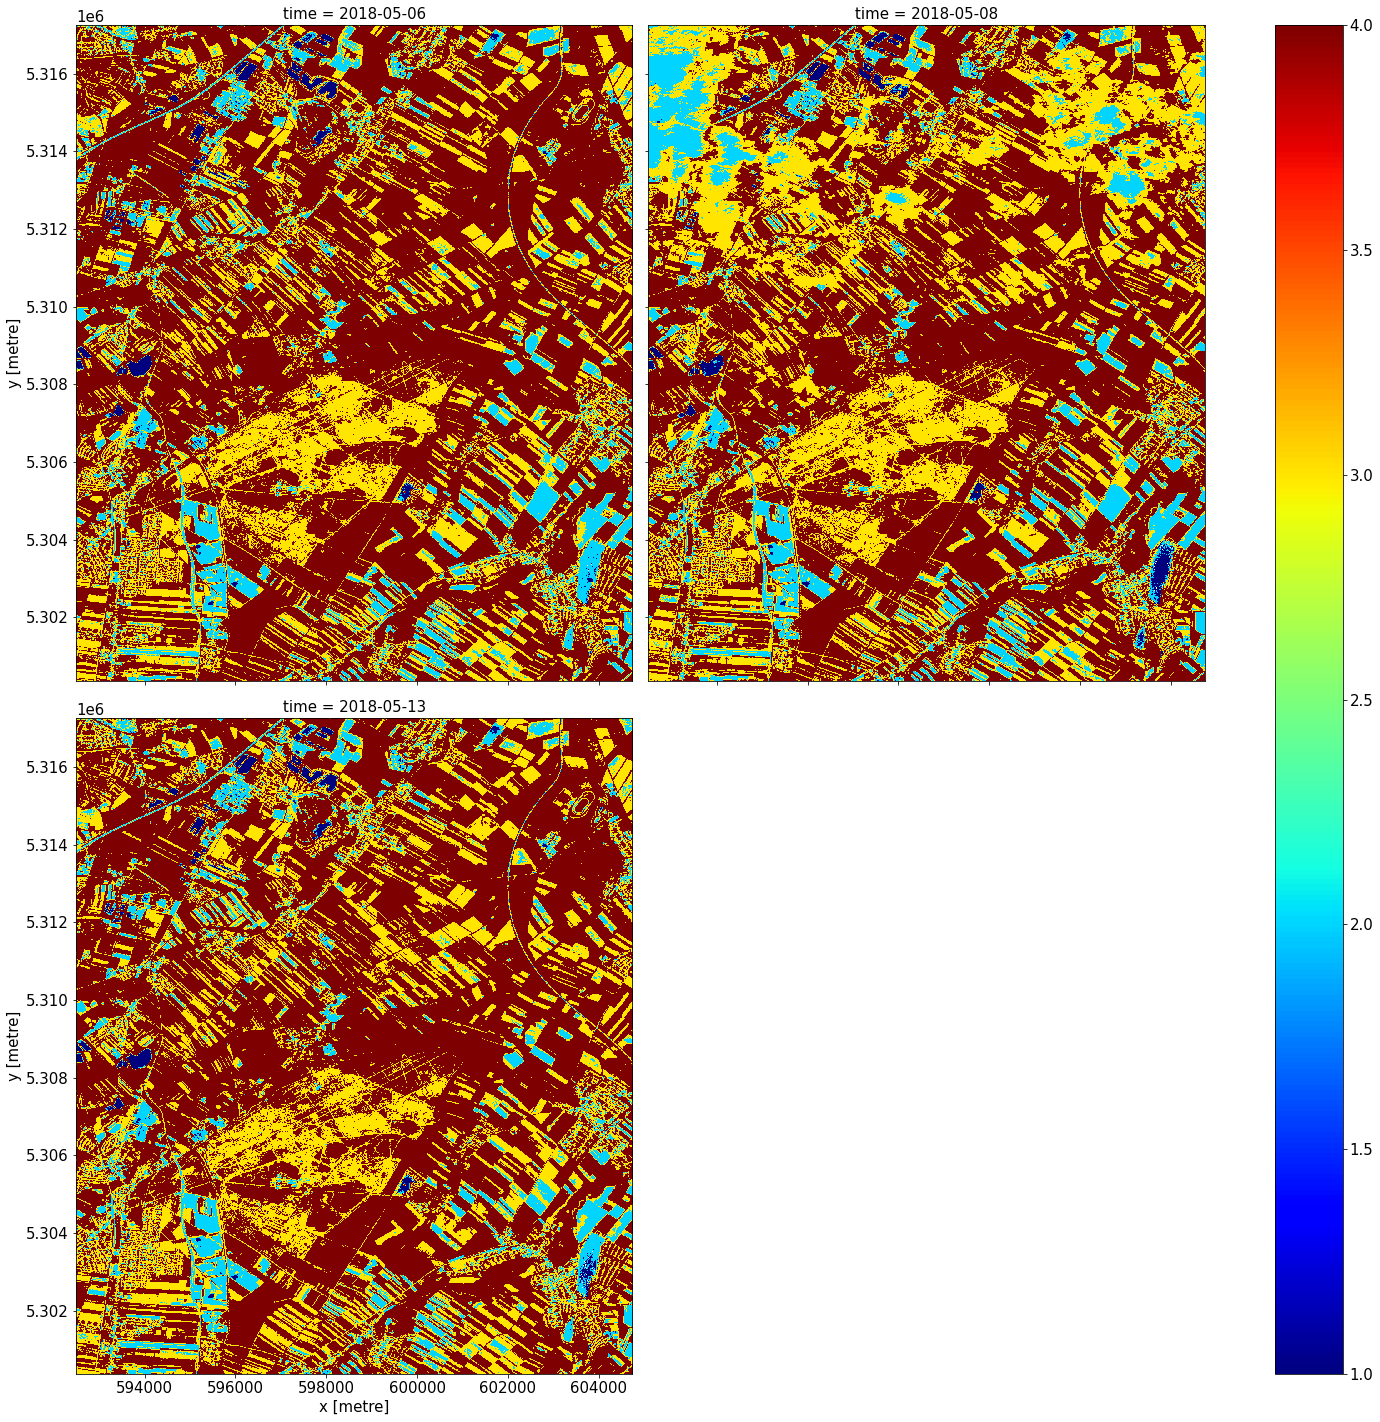

In [7]:
mask_waterbody = 1 * ndvi.where(ndvi <= 0, other=0)/ndvi
mask_soil = 2 * ndvi.where((0 < ndvi) & (ndvi <= 0.2), other=0)/ndvi
mask_grassland = 3 * ndvi.where((0.2 < ndvi) & (ndvi <= 0.5), other=0)/ndvi
mask_forest = 4 * ndvi.where(ndvi > 0.5, other=0)/ndvi
ndvi_classified = mask_forest + mask_grassland + mask_soil + mask_waterbody
ndvi_classified.plot.imshow(x='x', 
                 y='y',
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='jet')

## NDWI Classification

* 1 - Waterbody > 0.5 
* 2 - Land x<=0.5

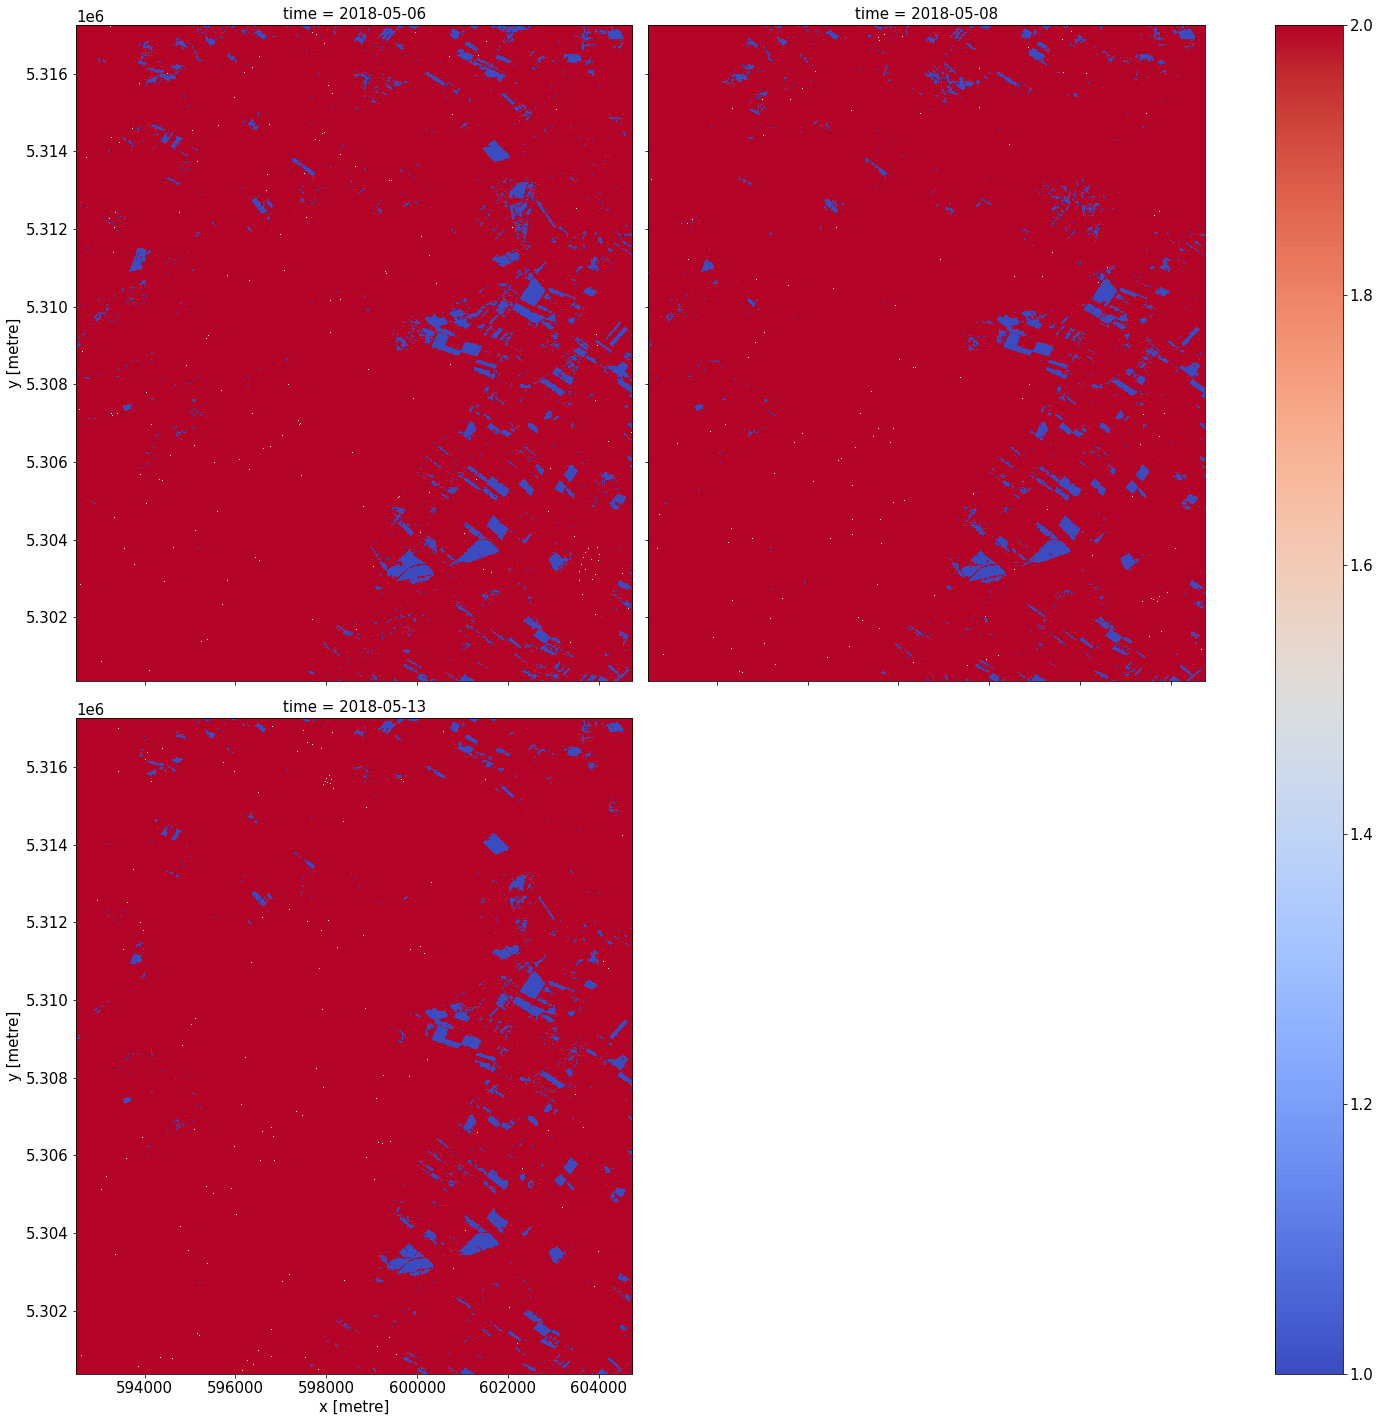

In [8]:
ndwi_mask_waterbody = 1 * ndwi.where(ndwi > 0.5, other=0)/ndwi
ndwi_mask_land = 2 * ndwi.where(ndwi <= 0.5, other=0)/ndwi
ndwi_classified = ndwi_mask_waterbody + ndwi_mask_land
ndwi_classified.plot.imshow(x='x', 
                 y='y',
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='coolwarm')